In [1]:
# 0.0 import packages

import shutil
import os
import time
import sys
import string
import mido
import numpy as np
import pandas as pd

from scipy import signal
import audiosegment
from pydub import AudioSegment as AS
import librosa

from tqdm import tqdm

import matplotlib.pyplot as plot

c:\Users\Marco\AppData\Local\Programs\Python\Python310\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
# 0.1 midi mappings from groove dataset
# kick drum
BASS = 36
# snare drum
SNARE_HEAD = 38
SNARE_RIM = 40
SNARE_X_STICK = 37
# toms
TOM_1_HEAD = 48
TOM_1_RIM = 50
TOM_2_HEAD = 45
TOM_2_RIM = 47
TOM_3_HEAD = 43
TOM_3_RIM = 58
# hi-hats
HH_OPEN_BOW = 46
HH_OPEN_EDGE = 26
HH_CLOSED_BOW = 42
HH_CLOSED_EDGE = 22
HH_PEDAL = 44
# crash cymbal
CRASH_1_BOW = 49
CRASH_1_EDGE = 55
CRASH_2_BOW = 57
CRASH_2_EDGE = 52
# ride cymbal
RIDE_BOW = 51
RIDE_EDGE = 59
RIDE_BELL = 53

# mappings for our own training (9)
KICK = 0
SNARE = 1
HH_CLOSED = 2
HH_OPEN = 3
RIDE = 4
TOM_1 = 5
TOM_2 = 6
TOM_3 = 7
CRASH = 8
NUM_FEATS = 9

# groove mappings to our mappings
KICK_LIST = [BASS]
SNARE_LIST = [SNARE_HEAD, SNARE_RIM, SNARE_X_STICK]
HH_CLOSED_LIST = [HH_CLOSED_BOW, HH_CLOSED_EDGE, HH_PEDAL]
HH_OPEN_LIST = [HH_OPEN_BOW, HH_OPEN_EDGE]
RIDE_LIST = [RIDE_BOW, RIDE_EDGE, RIDE_BELL]
TOM_1_LIST = [TOM_1_HEAD, TOM_1_RIM]
TOM_2_LIST = [TOM_2_HEAD, TOM_2_RIM]
TOM_3_LIST = [TOM_3_HEAD, TOM_3_RIM]
CRASH_LIST = [CRASH_1_BOW, CRASH_1_EDGE, CRASH_2_BOW, CRASH_2_EDGE]


In [3]:
# 1.0 load groove dataset

groove_csv = pd.read_csv('data/groove/info.csv')
print("groove dataset:", len(groove_csv))

# get train, test, and validation sets
train_csv = []
test_csv = []
validation_csv = []

for index, row in groove_csv.iterrows():
    if str(row.audio_filename).lower() != "nan":
        split = row['split']
        if split == "train":
            train_csv.append(row)
        elif split == "test":
            test_csv.append(row)
        elif split == "validation":
            validation_csv.append(row)
        
print ("train: ", len(train_csv))
print ("test: ", len(test_csv))
print ("validation: ", len(validation_csv))

groove dataset: 1150
train:  846
test:  124
validation:  120


In [4]:
# 1.1 code to convert midi file to array
# https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c

def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        value = 1 if velocity > 0 else 0
        result[note-21] = value if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2array(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    # sums = all_arys.sum(axis=1)
    # ends = np.where(sums > 0)[0]
    return all_arys #[min(ends): max(ends)]

In [42]:
# 2.0 functions for feature and label extraction

default_sample_rate = 44100

# resets temp folder
def reset_temp_folder():
    if os.path.isfile('temp/'):
        shutil.rmtree('temp/', ignore_errors=True)
    if not os.path.exists('temp/'):
        os.mkdir('temp/')

# converts an audio file to log mel array
def audio_to_melspec_array(wav_file_path, window_size, window_stride, sample_rate=default_sample_rate):
    n_dft = int(sample_rate * window_size)
    n_mels = 128
    win_length = 1024
    hop_length = int(sample_rate * window_stride)
    # load in wav file and remove the mean of the signal
    y, sr = librosa.load(wav_file_path, sr=sample_rate)
    y = y - y.mean()
    y = np.append(y[0],y[1:]-.97*y[:-1])
    # compute mel spectrogram
    stft = librosa.stft(y, n_fft=n_dft, hop_length=hop_length, win_length=win_length, window=signal.hamming)
    spec = np.abs(stft)**2
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_dft, n_mels=n_mels, fmin=20)
    melspec = np.dot(mel_basis, spec)
    logspec = librosa.power_to_db(melspec, ref=np.max)
    logspec = np.transpose(logspec)
    # plot.imshow(logspec.T, origin='lower', aspect='auto')
    # plot.show()
    # turn into tensor
    # logspec_tensor = torch.tensor(logspec)
    return logspec

# reformats midi array for training
def reformat_midi(midi_array):
    midi_array = midi_array.T # transpose midi array for easy access
    T_steps = midi_array.shape[1] # get number of time steps
    # kicks
    kick_midi = np.zeros((T_steps), dtype='int64')
    for val in KICK_LIST:
        kick_midi += midi_array[val-21]
    kick_midi = np.where(kick_midi > 0, 1, 0)
    # snares
    snare_midi = np.zeros((T_steps), dtype='int64')
    for val in SNARE_LIST:
        snare_midi += midi_array[val-21]
    snare_midi = np.where(snare_midi > 0, 1, 0)
    # hh_close
    hh_close_midi = np.zeros((T_steps), dtype='int64')
    for val in HH_CLOSED_LIST:
        hh_close_midi += midi_array[val-21]
    hh_close_midi = np.where(hh_close_midi > 0, 1, 0)
    # hh_open
    hh_open_midi = np.zeros((T_steps), dtype='int64')
    for val in HH_OPEN_LIST:
        hh_open_midi += midi_array[val-21]
    hh_open_midi = np.where(hh_open_midi > 0, 1, 0)
    # ride
    ride_midi = np.zeros((T_steps), dtype='int64')
    for val in RIDE_LIST:
        ride_midi += midi_array[val-21]
    ride_midi = np.where(ride_midi > 0, 1, 0)
    # tom 1
    tom1_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_1_LIST:
        tom1_midi += midi_array[val-21]
    tom1_midi = np.where(tom1_midi > 0, 1, 0)
    # tom 2
    tom2_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_2_LIST:
        tom2_midi += midi_array[val-21]
    tom2_midi = np.where(tom2_midi > 0, 1, 0)
    # tom 3
    tom3_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_3_LIST:
        tom3_midi += midi_array[val-21]
    tom3_midi = np.where(tom3_midi > 0, 1, 0)
    # crash
    crash_midi = np.zeros((T_steps), dtype='int64')
    for val in CRASH_LIST:
        crash_midi += midi_array[val-21]
    crash_midi = np.where(crash_midi > 0, 1, 0)
    
    reformated_midi_array = np.zeros((midi_array.shape[1], NUM_FEATS), dtype='int64')
    reformated_midi_array[:,KICK] = kick_midi
    reformated_midi_array[:,SNARE] = snare_midi
    reformated_midi_array[:,HH_CLOSED] = hh_close_midi
    reformated_midi_array[:,HH_OPEN] = hh_open_midi
    reformated_midi_array[:,RIDE] = ride_midi
    reformated_midi_array[:,TOM_1] = tom1_midi
    reformated_midi_array[:,TOM_2] = tom2_midi
    reformated_midi_array[:,TOM_3] = tom3_midi
    reformated_midi_array[:,CRASH] = crash_midi
    return reformated_midi_array

# shrinks an array down keeping the distance between values proportional
def shrink_array_proportionally(midi_array, target_resize):
    resized_array = np.zeros((target_resize, midi_array.shape[1]))
    ratio = midi_array.shape[0] / target_resize
    # iterate through each time-step
    for t in range(midi_array.shape[0]): 
        # for each value
        for i in range(midi_array.shape[1]):
            value = midi_array[t][i]
            if value > 0:
                t2 = int(t / ratio)
                resized_array[t2][i] = value
    return resized_array

# converts a midi array to a list of arrays
def midi_to_arrays(midi_array, num_arrays, array_length):
    midi_arrays = []
    split_midi_arrays = np.array_split(midi_array, num_arrays)
    #print ("midi array len: ", len(midi_array))
    #print ("split list len: ", len(split_midi_arrays))
    for i in range(len(split_midi_arrays)):
        #print ("shape: ", split_midi_arrays[i].shape)
        # only add array if correct size
        if split_midi_arrays[i].shape == (array_length, NUM_FEATS):
            midi_arrays.append(split_midi_arrays[i])
    return midi_arrays

# removes rows from midi_array if they are all 0
def cut_leading_ending_zeros(midi_array):
    # delete leading zeros
    leading_zeros = 0
    example = np.zeros(NUM_FEATS, dtype='int32')
    for t in range(midi_array.shape[0]):
        row = np.array(midi_array[t,:], dtype='int32')
        if np.array_equal(row, example):
            leading_zeros += 1
        else:
            break
    if leading_zeros > 0:
        midi_array = np.delete(midi_array, np.s_[0:leading_zeros], axis=0)
    # delete ending zeros
    ending_zeros = 0
    for t in range(midi_array.shape[0]-1, -1, -1):
        row = np.array(midi_array[t,:], dtype='int32')
        if np.array_equal(row, example):
            ending_zeros += 1
        else:
            break
    print('ending zeros: ', ending_zeros, ' shape b4: ', midi_array.shape)
    if ending_zeros > 0:
        midi_array = midi_array[:-ending_zeros]
    print('ending zeros: ', ending_zeros, ' shape after: ', midi_array.shape)
    return midi_array, leading_zeros, ending_zeros

# slice midi based on ticks per seg (x ticks = 1 segment index)
def slice_midi(midi_array, ticks_per_seg):
    # get midi segments
    midi_segments = []
    for t in range(0, midi_array.shape[0], ticks_per_seg):
        segment = np.zeros(NUM_FEATS, dtype='int32')
        for inst in range(NUM_FEATS):
            sum = 0
            for i in range(ticks_per_seg):
                if (t+i < midi_array.shape[0]):
                    sum += midi_array[t+i][inst]
            sum /= ticks_per_seg
            if (sum >= 0.5):
                segment[inst] = 1
        midi_segments.append(segment)
    midi_segments = np.array(midi_segments, dtype='int64')
    return midi_segments

def remove_leading_silence(wav_array):
    leading_silence = 0
    for t in range(len(wav_array)):
        if wav_array[t] == 0 or wav_array[t] == -1 or wav_array[t] == 1:
            leading_silence += 1
        else:
            break
    if leading_silence > 0:
        wav_array = wav_array[leading_silence:]
    return wav_array
        
def show_midi_plot(midi_array):
    midi_array = np.flip(midi_array.T, axis=0)
    f = plot.figure()
    f.set_figwidth(20)
    f.set_figheight(10)
    plot.imshow(midi_array, cmap='binary', interpolation='None', aspect="auto")
    plot.show()
    return f
    
def show_spectrograph(spec_array):
    spec_array = np.flip(spec_array.T, axis=0)
    f = plot.figure()
    f.set_figwidth(20)
    f.set_figheight(10)
    plot.imshow(spec_array, cmap='magma', interpolation='None', aspect="auto")
    plot.show()
    
def show_midi_over_spec(spec_array, midi_array):
    midi_array = np.flip(midi_array.T, axis=0)
    spec_array = np.flip(spec_array.T, axis=0)
    fig = plot.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    plot.imshow(spec_array, 'magma', interpolation='None', aspect="auto")
    plot.imshow(midi_array, 'binary', interpolation='None', alpha=0.5, aspect="auto")
    plot.show()

def get_data_segs(data_index, audio_data_per_seg):
    # load in midi file
    midi_file_path = "data/groove/" + data_index.midi_filename
    midi = mido.MidiFile(midi_file_path)
    # convert midi to array
    midi_array = mid2array(midi)
    calculated_length = mido.tick2second(midi_array.shape[0], ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm))
    # reformat midi array for training
    midi_array = reformat_midi(midi_array)
    # show_midi_plot(midi_array)
    #print ("reformated midi_array.shape: ", midi_array.shape)
    # cut leading zeros
    midi_array, leading_zeros, ending_zeros = cut_leading_ending_zeros(midi_array)
    leading_removed = mido.tick2second(leading_zeros, ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm))
    ending_removed = mido.tick2second(ending_zeros, ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm))
    new_midi_duration = mido.tick2second(midi_array.shape[0], ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(data_index.bpm))
    print ('starting length: ', midi.length)
    print ('calculated starting length: ', calculated_length)
    print ('leading removed: ', leading_removed)
    print ('ending removed: ', ending_removed)
    print ('new_midi duration: ', new_midi_duration)
    #show_midi_plot(midi_array)
    print ("removed starting zeros midi_array.shape: ", midi_array.shape)
    ticks_per_beat = midi.ticks_per_beat
    ticks_per_16th = int(ticks_per_beat / 16)
    print ('ticks_per_16th', ticks_per_16th)
    midi_segments = slice_midi(midi_array, ticks_per_16th)
    print ('len(midi_segments): ', len(midi_segments))
    #print ('midi_segments: ', midi_segments)
    show_midi_plot(midi_segments)


    # load in wav file
    audio_file_path = "data/groove/" + data_index.audio_filename
    wav_file = audiosegment.from_file(audio_file_path)
    print ('wav file duration: ', wav_file.duration_seconds)
    
    # convert sample width if not set to 2 (16 bits)
    if wav_file.sample_width != 2:
        wav_file = wav_file.set_sample_width(2)
        # print("\tnew sample_width: ", wav_file.sample_width)
        wav_file.export(audio_file_path, format="wav")
    # convert file from stereo to mono if channels > 1
    if wav_file.channels != 1:
        wav_file = wav_file.set_channels(1)
        wav_file.export(audio_file_path, format="wav")
    # remove starting silence from wav file
    wav_array = wav_file.to_numpy_array()
    wav_array = remove_leading_silence(wav_array)
    wav_file = audiosegment.from_numpy_array(wav_array, framerate=wav_file.frame_rate)
    print ('new wav file duration: ', wav_file.duration_seconds)
    # cut wavfile to be same length in seconds as midi
    if wav_file.duration_seconds > new_midi_duration:
        resized_wav_file = wav_file.dice(new_midi_duration, zero_pad=False)
    wav_file = resized_wav_file[0]
    
    # show wav file spec
    freqs, times, amps = wav_file.spectrogram(window_length_s=0.002, overlap=0.5)
    amps = 10 * np.log10(amps + 1e-9)
    plot.pcolormesh(times, freqs, amps)
    plot.xlabel("Time in Seconds")
    plot.ylabel("Frequency in Hz")
    plot.show()
    
    print ('resized wav file duration: ', wav_file.duration_seconds)
    segment_duration = wav_file.duration_seconds / len(midi_segments)
    print ('segment_duration: ', segment_duration)
    diced_wav_file = wav_file.dice(segment_duration, zero_pad=False)
    while len(diced_wav_file) > len(midi_segments):
        diced_wav_file.pop()
    print ('diced len: ', len(diced_wav_file))
    
    # apply mel filer to audio segments
    formated_audio = []
    for seg in diced_wav_file:
        freqs, times, amps = seg.spectrogram(window_length_samples=audio_data_per_seg, overlap=0.5)
        # amps = 10 * np.log10(amps + 1e-9)
        # plot.pcolormesh(times, freqs, amps)
        # plot.xlabel("Time in Seconds")
        # plot.ylabel("Frequency in Hz")
        # plot.show()
        # print ('freqs: ', len(freqs), ' times: ', len(times), ' amps: ', len(amps))
        formated_audio.append(amps)
    formated_audio_array = np.array(formated_audio, dtype='float32')
    print ('formated_audio_array.shape: ', formated_audio_array.shape)
    return formated_audio_array, midi_segments
    
def index_to_arrays(csv_index, segment_length, window_size, window_stride):
    # load in wav file
    audio_file_path = "data/groove/" + csv_index.audio_filename
    wav_file = audiosegment.from_file(audio_file_path)
    #print ("sample rate: ", wav_file.frame_rate)
    #print ("wav duration: ", wav_file.duration_seconds)
    # convert sample width if not set to 2 (16 bits)
    if wav_file.sample_width != 2:
        wav_file = wav_file.set_sample_width(2)
        # print("\tnew sample_width: ", wav_file.sample_width)
        wav_file.export(audio_file_path, format="wav")
    # convert file from stereo to mono if channels > 1
    if wav_file.channels != 1:
        wav_file = wav_file.set_channels(1)
        wav_file.export(audio_file_path, format="wav")
    # cutting and padding
    diced_wav_files = wav_file.dice(segment_length, zero_pad=False)
    #print ("diced wav files len: ", len(diced_wav_files))
    target_len = segment_length * wav_file.frame_rate
    feats_list = []
    zeros_padded_amount = 0
    i = 0
    for diced_file in diced_wav_files:
        # pad with zeros if not correct length
        diced_file_len = len(diced_file.to_numpy_array())
        #print ("\tdiced file len: ", diced_file_len)
        if diced_file_len != target_len:
            zeros = int(target_len - diced_file_len)
            zeros_padded_amount = ((zeros / target_len) * segment_length) / wav_file.duration_seconds
            #print ("zeros_padded_amount: ", zeros_padded_amount * 100, " %")
            diced_array = np.pad(diced_file.to_numpy_array(), (0, zeros))
            diced_file = audiosegment.from_numpy_array(diced_array, framerate=default_sample_rate)
        # export temp wav file and convert to tensor
        diced_file_path = str(csv_index.id) + "-" + str(i) + ".wav"
        diced_file_path = diced_file_path.replace('/', '-')
        diced_file_path = "temp/" + diced_file_path
        diced_file.export(diced_file_path, format="wav")
        feats_array = audio_to_melspec_array(diced_file_path, window_size, window_stride, wav_file.frame_rate)
        feats_list.append(feats_array)
        i += 1
    # return numpy array
    feats_list = np.array(feats_list, dtype='float64')
    
    # load in midi file
    midi_file_path = "data/groove/" + csv_index.midi_filename
    midi = mido.MidiFile(midi_file_path)
    # convert midi to array
    midi_array = mid2array(midi)
    #show_midi_plot(midi_array)
    
    # reformat midi array for training
    midi_array = reformat_midi(midi_array)
    #show_midi_plot(midi_array)
    #print ("reformated midi_array.shape: ", midi_array.shape)
    
    # cut or pad midi array to match wav file length
    if midi.length > wav_file.duration_seconds:
        cut_amount = midi.length - wav_file.duration_seconds
        cut_amount = cut_amount / midi.length
        cut_amount = int(cut_amount * midi_array.shape[0])
        midi_array = midi_array[0: midi_array.shape[0] - cut_amount, :]
    
    # pad midi array to be proportionally same length as wav file w padded zeros 
    if zeros_padded_amount > 0:
        zeros = int(midi_array.shape[0] * zeros_padded_amount)
        zeros_pad = np.zeros((zeros, midi_array.shape[1]))
        midi_array = np.concatenate((midi_array, zeros_pad))
    #show_midi_plot(midi_array)

    # resize array to be directly related to duration of the audio file (every second is 100 units)
    target_resize = int(feats_list.shape[0] * feats_list.shape[1])
    #print ("current midi array size: ", midi_array.shape[0], " target size: ", target_resize)
    midi_array = shrink_array_proportionally(midi_array, target_resize)
    #show_midi_plot(midi_array)
    #print ("shrinked midi_array.shape: ", midi_array.shape)

    # create label arrays
    labels_list = midi_to_arrays(midi_array, len(feats_list), feats_list.shape[1])
    # return numpy arrays
    labels_list = np.array(labels_list, dtype='int64')
    
    #print ("labels: ", labels_list.shape)
    
    return feats_list , labels_list

  0%|          | 0/1 [00:00<?, ?it/s]

0  file:  drummer1/session1/10_jazz-funk_116_fill_4-4.wav   1.872843  sec
ending zeros:  1047  shape b4:  (2779, 9)
ending zeros:  1047  shape after:  (1732, 9)
starting length:  3.0010753854166663
calculated starting length:  3.0010753854166663
leading removed:  0.006465512499999999
ending removed:  1.1282319312499998
new_midi duration:  1.8663779416666664
removed starting zeros midi_array.shape:  (1732, 9)
ticks_per_16th 30
len(midi_segments):  58


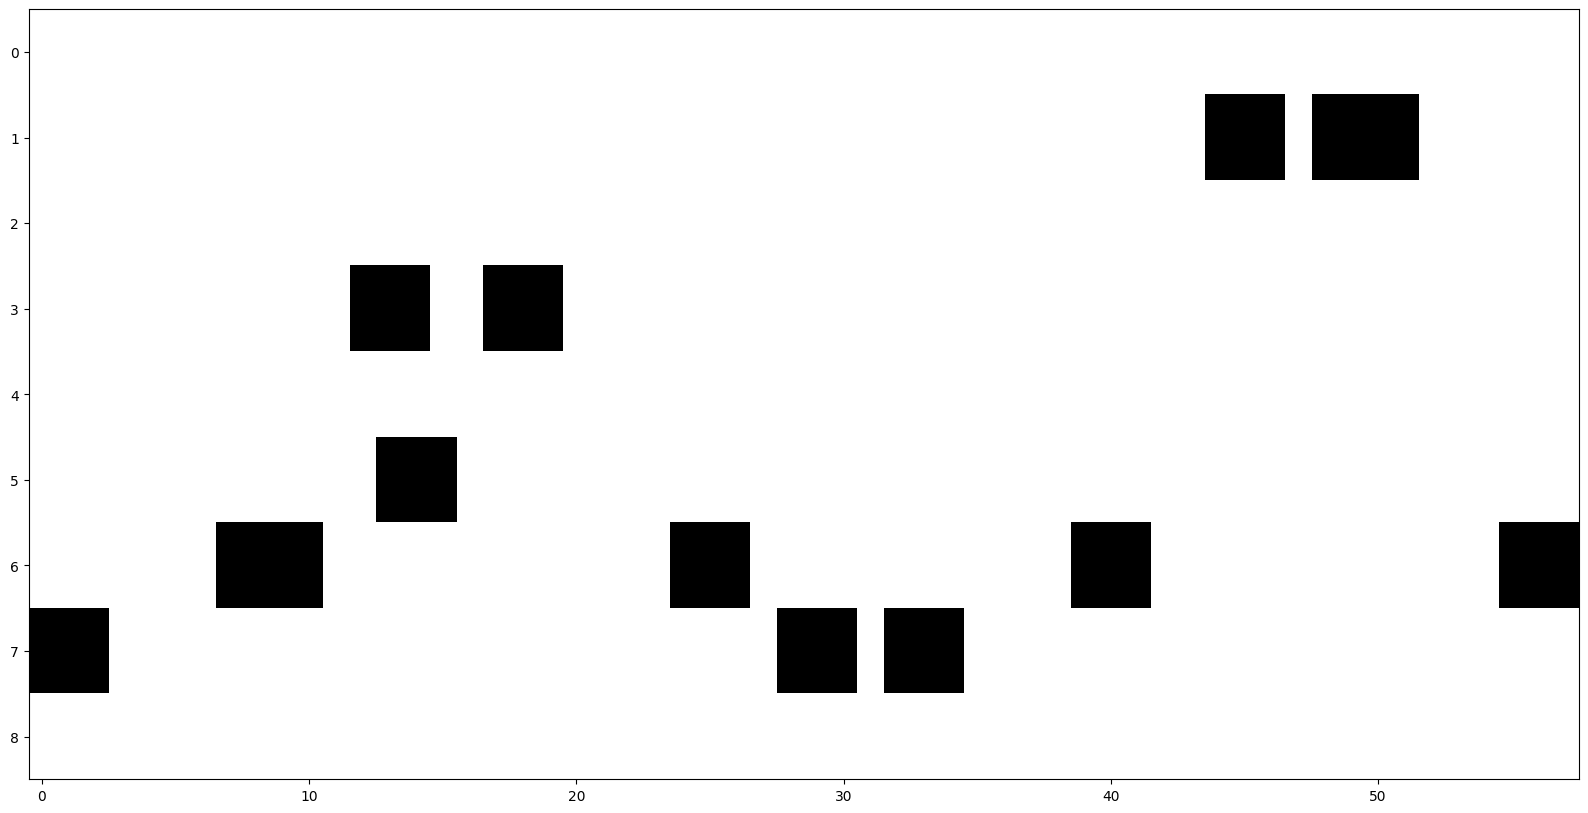

wav file duration:  2.0689569160997734
new wav file duration:  2.061927437641723


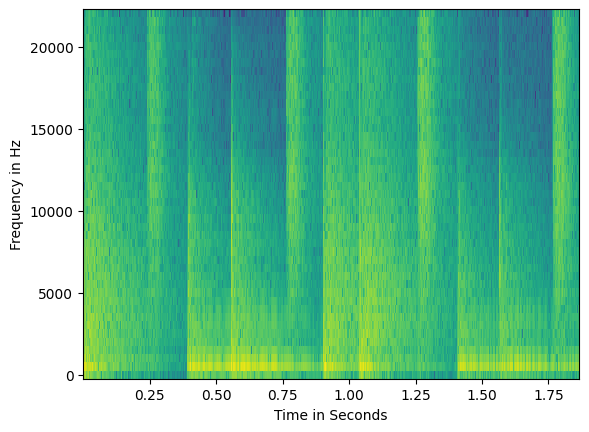

100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

resized wav file duration:  1.8663718820861679
segment_duration:  0.03217882555320979
diced len:  58
formated_audio_array.shape:  (58, 32, 44)
train_feats.shape:  (58, 32, 44)
train_labels.shape:  (58, 9)
time elapsed:  0.43  sec



In [43]:
# {dev only}

DEV_MODE = True
AUDIO_DATA_PER_SEG = 63

if DEV_MODE:
    # get complete list of train feats / labels
    
    dev_csv = []
    dev_csv.append(train_csv[1])
    
    
    startTime = time.time()
    feats_list = []
    labels_list = []

    for i, index in enumerate(tqdm(dev_csv)):
        print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
        feats, labels = get_data_segs(index, AUDIO_DATA_PER_SEG)
        for j in range(len(feats)):
            # print ("\t", j, " feats: ", feats[j].shape, " labels: ", labels[j].shape)
            # show_midi_plot(labels[j])
            # show_spectrograph(feats[j])
            # show_midi_over_spec(feats[j], labels[j])
            feats_list.append(feats[j])
            labels_list.append(labels[j])
    # make into numpy arrays
    feats_array = np.array(feats_list, dtype='float64')
    labels_array = np.array(labels_list, dtype='int64')
    print ("train_feats.shape: ", feats_array.shape)
    print ("train_labels.shape: ", labels_array.shape)
    # dataset complete
    print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")

In [ ]:
# convert midi to array and back to midi for testing

from ipynb.fs.full.convert_to_midi import convert_array_to_midi

# get correct index
train_index = 666
data = train_csv[train_index]
print ("data.name: ", data.audio_filename, " duration: ", data.duration, " sec")
data_id = '_' + data.audio_filename.split('/')[2]
data_id = data_id.split('.')[0]
print ("data_id: ", data_id)

# these values define the resolution of the data
segment_length = 4.99
window_size = 0.025
window_stride = 0.01

feats_list = []
labels_list = []
feats, labels = index_to_arrays(data, segment_length, window_size, window_stride)
for j in range(len(feats)):
        print ("\t", j, " feats: ", feats[j].shape, " labels: ", labels[j].shape)
        # show_midi_plot(labels[j])
        # show_spectrograph(feats[j])
        # show_midi_over_spec(feats[j], labels[j])
        feats_list.append(feats[j])
        labels_list.append(labels[j])
# make into numpy arrays
feats = np.array(feats_list, dtype='float64')
labels = np.array(labels_list, dtype='int64')
print ("feats.shape: ", feats.shape)
print ("labels.shape: ", labels.shape)
# create dataset folder if it does not exist
if not os.path.exists('data/midi'):
        os.mkdir('data/midi')
# save to file
np.save("data/midi/data" + data_id + ".npy", labels, allow_pickle=True)

# convert back to midi
np_array = np.load("data/midi/data" + data_id + ".npy", allow_pickle=True)
np_array = np_array.reshape(np_array.shape[0]*np_array.shape[1], np_array.shape[2])
print ("np array shape: ", np_array.shape)

show_midi_plot(np_array)

length_seconds = int(np.ceil(segment_length)) * labels.shape[0]
midi_file = convert_array_to_midi(np_array, length_seconds)
midi_file.save("data/midi/midi" + data_id + ".mid")

In [ ]:
# 3.0 run dataset creation loops - save to file

np.set_printoptions(threshold=sys.maxsize)

# data id (used to make different datasets)
data_id = '_5s_20hz'
print ("DATASET ID: ", data_id)

# these values define the resolution of the data
segment_length = 4.99
window_size = 0.025
window_stride = 0.01

# reset temp folder
reset_temp_folder()

#########################################
#                                       #
#           TRAINING DATA               #
#                                       #
#########################################

# get complete list of train feats / labels
print ("starting training dataset creation...")
startTime = time.time()
train_feats = []
train_labels = []

for i, index in enumerate(tqdm(train_csv)):
    # print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = index_to_arrays(index, segment_length, window_size, window_stride)
    for j in range(len(feats)):
        # print ("\t", j, " feats: ", feats[j].shape, " labels: ", labels[j].shape)
        # show_midi_plot(labels[j])
        # show_spectrograph(feats[j])
        # show_midi_over_spec(feats[j], labels[j])
        train_feats.append(feats[j])
        train_labels.append(labels[j])
# make into numpy arrays
train_feats = np.array(train_feats, dtype='float64')
train_labels = np.array(train_labels, dtype='int64')
print ("train_feats.shape: ", train_feats.shape)
print ("train_labels.shape: ", train_labels.shape)
# dataset complete
print ("training dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# create dataset folder if it does not exist
if not os.path.exists('data/dataset' + data_id):
        os.mkdir('data/dataset' + data_id)
# save feats / labels lists to file
np.save("data/dataset" + data_id + "/" + "train_feats" + data_id + ".npy", train_feats, allow_pickle=True)
np.save("data/dataset" + data_id + "/" + "train_labels" + data_id + ".npy", train_labels, allow_pickle=True)

#########################################
#                                       #
#               TEST DATA               #
#                                       #
#########################################

# get complete list of test feats / labels
print ("starting test dataset creation...")
startTime = time.time()
test_feats = []
test_labels = []
for i, index in enumerate(tqdm(test_csv)):
    #print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = index_to_arrays(index, segment_length, window_size, window_stride)
    for j in range(len(feats)):
        # show_midi_over_spec(feats[j], labels[j])
        test_feats.append(feats[j])
        test_labels.append(labels[j])
# make into numpy arrays
test_feats = np.array(test_feats, dtype='float64')
test_labels = np.array(test_labels, dtype='int64')
print ("test_feats.shape: ", test_feats.shape)
print ("test_labels.shape: ", test_labels.shape)
# dataset complete
print ("test dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# save feats / labels lists to file
np.save("data/dataset" + data_id + "/" + "test_feats" + data_id + ".npy", test_feats, allow_pickle=True)
np.save("data/dataset" + data_id + "/" + "test_labels" + data_id + ".npy", test_labels, allow_pickle=True)

#########################################
#                                       #
#           VALIDATION DATA             #
#                                       #
#########################################

# # get complete list of validation feats / labels
print ("starting validation dataset creation...")
startTime = time.time()
val_feats = []
val_labels = []
for i, index in enumerate(tqdm(validation_csv)):
    #print (i, " file: ", index.audio_filename, " ", index.duration, " sec")
    feats, labels = index_to_arrays(index, segment_length, window_size, window_stride)
    for j in range(len(feats)):
        # show_midi_over_spec(feats[j], labels[j])
        val_feats.append(feats[j])
        val_labels.append(labels[j])
# make into numpy arrays
val_feats = np.array(val_feats, dtype='float64')
val_labels = np.array(val_labels, dtype='int64')
print ("val_feats.shape: ", val_feats.shape)
print ("val_labels.shape: ", val_labels.shape)
# dataset complete
print ("validation dataset complete!")
print ("time elapsed: ", round((time.time() - startTime), 2), " sec\n")
# save feats / labels lists to file
np.save("data/dataset" + data_id + "/" + "val_feats" + data_id + ".npy", val_feats, allow_pickle=True)
np.save("data/dataset" + data_id + "/" + "val_labels" + data_id + ".npy", val_labels, allow_pickle=True)

# reset temp folder
reset_temp_folder()